Q. Does user's demographic(location, age, gender) impact type of anime(genre, episodes, anime type(OVA, movie), Rank) they are prefer?
For solving this question, I am trying to determine the rating of an anime based on user's demographic(Age, Location, Gender) and anime's features(genre, type and episodes)

The first algorithm I am trying is OrderedModel. I am trying to classify a given combination of user demographic and anime features to the probable rating by user.
This is because rating is a multiclass column. Plain logistic regression would be a bit lacking to predict the expected rating.
OrderedModel is more suitable for ordinal multiclass classification.

In [3]:
import pandas as pd
import numpy as np
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

data = pd.read_csv('../../joined_datasets/joined_rating_dataset.csv')
cleaned_dataset = pd.read_csv("../../cleaned_datasets/users_details_dataset_cleaned.csv")
data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5207686 entries, 0 to 5207685
Data columns (total 21 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Unnamed: 0        int64  
 1   user_id           int64  
 2   anime_id          int64  
 3   rating            int64  
 4   Gender            object 
 5   Location          object 
 6   Birthday_Date     object 
 7   Joined_Date       object 
 8   Age_Join          float64
 9   Episodes Watched  float64
 10  Age               float64
 11  Name              object 
 12  Genres            object 
 13  Type              object 
 14  Start Date        object 
 15  End Date          object 
 16  Studios           object 
 17  Source            object 
 18  Rank              object 
 19  Episodes          float64
 20  Episodes_Norm     float64
dtypes: float64(5), int64(4), object(12)
memory usage: 834.4+ MB


Performing undersampling as number of rows was a bit too high to compute using my laptop. Considering only the top 10 countries

In [4]:
df = cleaned_dataset.copy()
import pandas as pd
import matplotlib.pyplot as plt

location_user_counts = df['Location'].value_counts()

top_countries = df['Location'].value_counts().head(10)

# # Get the list of top 20 countries
top_10_countries = top_countries.index.tolist()
data = data[data['Location'].isin(top_10_countries)]
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3357313 entries, 0 to 5207685
Data columns (total 21 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Unnamed: 0        int64  
 1   user_id           int64  
 2   anime_id          int64  
 3   rating            int64  
 4   Gender            object 
 5   Location          object 
 6   Birthday_Date     object 
 7   Joined_Date       object 
 8   Age_Join          float64
 9   Episodes Watched  float64
 10  Age               float64
 11  Name              object 
 12  Genres            object 
 13  Type              object 
 14  Start Date        object 
 15  End Date          object 
 16  Studios           object 
 17  Source            object 
 18  Rank              object 
 19  Episodes          float64
 20  Episodes_Norm     float64
dtypes: float64(5), int64(4), object(12)
memory usage: 563.5+ MB


In [5]:
# Undersampling
# Count entries for each location
location_counts = data['Location'].value_counts()

# Decide the target sample size (e.g., use the minimum count of the top 5 locations)
target_sample_size = location_counts.nsmallest(5).min()  # Choose the minimum of the top 5

# Under-sample the DataFrame
under_sampled_df = data.groupby('Location').apply(lambda x: x.sample(n=min(len(x), target_sample_size), random_state=42)).reset_index(drop=True)

# Count occurrences of each class in the target variable (assuming your target variable is 'rating')
target_counts = under_sampled_df['Location'].value_counts()
# Output the results
print("Under-sampled DataFrame shape:", under_sampled_df.shape)
print("Counts of each class in the target variable:")
print(target_counts)

/var/folders/dz/fg9tl53x4y16ytgmdhwdt0kr0000gn/T/ipykernel_85581/807053095.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  under_sampled_df = data.groupby('Location').apply(lambda x: x.sample(n=min(len(x), target_sample_size), random_state=42)).reset_index(drop=True)


Under-sampled DataFrame shape: (1075590, 21)
Counts of each class in the target variable:
Location
Australia        107559
Brazil           107559
Canada           107559
France           107559
Germany          107559
Philippines      107559
Poland           107559
Russia           107559
Sweden           107559
United States    107559
Name: count, dtype: int64


Checking if more undersampling is needed based on ratings.

Class = 10, n=142811 (13.28%)
Class = 9, n=193198 (17.96%)
Class = 6, n=123165 (11.45%)
Class = 8, n=264913 (24.63%)
Class = 7, n=243352 (22.62%)
Class = 5, n=61613 (5.73%)
Class = 4, n=25777 (2.40%)
Class = 2, n=5855 (0.54%)
Class = 3, n=10901 (1.01%)
Class = 1, n=4005 (0.37%)


<Axes: title={'center': 'Count (target)'}, xlabel='rating'>

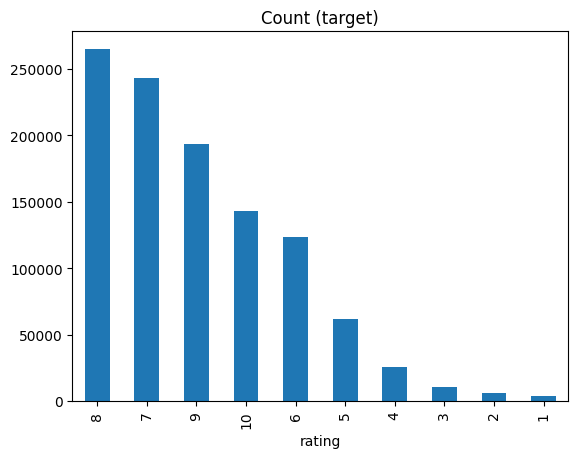

In [6]:
from collections import Counter

counter = Counter(under_sampled_df["rating"])

for k, v in counter.items():
    per = 100*v/len(under_sampled_df["rating"])
    print(f"Class = {k}, n={v} ({per:.2f}%)")

target_count = under_sampled_df["rating"].value_counts()
target_count.plot(kind='bar', title='Count (target)')

In [8]:
data.columns

Index(['Unnamed: 0', 'user_id', 'anime_id', 'rating', 'Gender', 'Location',
       'Birthday_Date', 'Joined_Date', 'Age_Join', 'Episodes Watched', 'Age',
       'Name', 'Genres', 'Type', 'Start Date', 'End Date', 'Studios', 'Source',
       'Rank', 'Episodes', 'Episodes_Norm'],
      dtype='object')

Converting the columns with string data to 1 hot encoded columns. Location to multiple columns with country name, gender to male, non-binary, genres to Adventure etc.
Splitting genres was a bit more tricky as there are multiple genres in each entry of genres column. 

In [32]:
# Select features for the model - adjust based on your dataset
features = ['Gender', 'Location', 'Age', 'Genres', 'Type', 'Episodes', 'Rank']
target = 'rating'

# One-hot encode categorical features
df = pd.get_dummies(under_sampled_df, columns=['Gender', 'Location', 'Type'],drop_first=True)


# Split the 'Genres' column into lists of individual genres
df['Genres'] = df['Genres'].str.strip().str.replace(', ', ',').str.replace(' ,', ',').str.split(',')

# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# One-hot encode the genres and create a DataFrame with separate columns for each genre
genres_one_hot = pd.DataFrame(mlb.fit_transform(df['Genres']), columns=mlb.classes_, index=df.index)
genres_one_hot = genres_one_hot.add_prefix("Genre_")


# Concatenate the one-hot encoded genres back to the original DataFrame and drop the original 'Genres' column
df = pd.concat([df, genres_one_hot], axis=1).drop('Genres', axis=1)


<class 'pandas.core.frame.DataFrame'>
Index: 808423 entries, 0 to 1075589
Data columns (total 52 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Unnamed: 0              808423 non-null  float64
 1   user_id                 808423 non-null  float64
 2   anime_id                808423 non-null  float64
 3   rating                  808423 non-null  float64
 4   Birthday_Date           808423 non-null  object 
 5   Joined_Date             808423 non-null  object 
 6   Age_Join                808423 non-null  float64
 7   Episodes Watched        808423 non-null  float64
 8   Age                     808423 non-null  float64
 9   Name                    808423 non-null  object 
 10  Start Date              808423 non-null  object 
 11  End Date                808423 non-null  object 
 12  Studios                 808423 non-null  object 
 13  Source                  808423 non-null  object 
 14  Rank                    

In [33]:
df = df.astype({col: 'float' for col in df.select_dtypes(include=['bool']).columns})
df = df.astype({col: 'float' for col in df.select_dtypes(include=['int64', 'float64']).columns})
df = df.dropna()
df = df[df["Rank"]!="UNKNOWN"]

Dropping columns with no data

In [34]:

genre_columns = [col for col in df.columns if col.startswith("Genre_")]


genre_counts = df[genre_columns].sum()


zero_count_genres = genre_counts[genre_counts == 0].index
zero_count_genres
df = df.drop(columns=zero_count_genres)

Dropping type columns with no data

In [35]:
type_columns = [col for col in df.columns if col.startswith("Type_")]


type_counts = df[type_columns].sum()


zero_count_types = type_counts[type_counts == 0].index
df = df.drop(columns=zero_count_types)

Standardizing the columns with high variance data, to a small range(0-1)

In [46]:
# Standardize the features
features = df.columns.difference(['user_id', 'anime_id', 'rating', 'Birthday_Date', 'Joined_Date', 'Age_Join', 'Episodes Watched',
                                  'Start Date', 'End Date', 'Name', 'Rank', 'Studios', 'Source', 'Episodes_Norm', 'Unnamed: 0'])
from sklearn.preprocessing import LabelEncoder, StandardScaler
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features])

In [61]:


# # Split the data
X = df_scaled

y = df[target]

y = y.astype('category')


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [51]:
# Fit an Ordinal Logistic Regression model
model = OrderedModel(y_train, X_train, distr='logit')
model_fit = model.fit(method='bfgs')
print(model_fit.summary())

# Coefficient significance
print(model_fit.pvalues)
print(model_fit.conf_int())



/Users/ramachandrank/Repos/MS/sem1/.venv/lib/python3.12/site-packages/statsmodels/miscmodels/ordinal_model.py:205: Warning: the endog has ordered == False, risk of capturing a wrong order for the categories. ordered == True preferred.
  warnings.warn("the endog has ordered == False, "


Optimization terminated successfully.
         Current function value: 1.809041
         Iterations: 76
         Function evaluations: 77
         Gradient evaluations: 77
                             OrderedModel Results                             
Dep. Variable:                 rating   Log-Likelihood:            -1.1700e+06
Model:                   OrderedModel   AIC:                         2.340e+06
Method:            Maximum Likelihood   BIC:                         2.341e+06
Date:                Tue, 05 Nov 2024                                         
Time:                        01:05:53                                         
No. Observations:              646738                                         
Df Residuals:                  646693                                         
Df Model:                          36                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

It seems the accuracy is not very high. This is probably due to the difference in the number of ratings for higher values(>5) than ratings(<5>)

In [62]:
import numpy as np
from sklearn.metrics import mean_squared_error, accuracy_score
# Predict probabilities on the test set
predicted_probs = model_fit.predict(X_test)

# Convert probabilities to predicted ratings by selecting the category with the highest probability
predicted_ratings = np.argmax(predicted_probs, axis=1)

y_test = y_test.cat.codes 

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predicted_ratings)
accuracy = accuracy_score(y_test, predicted_ratings)

print("Mean Squared Error:", mse)
print("Accuracy:", accuracy)

Mean Squared Error: 2.736833967282061
Accuracy: 0.260828153508365


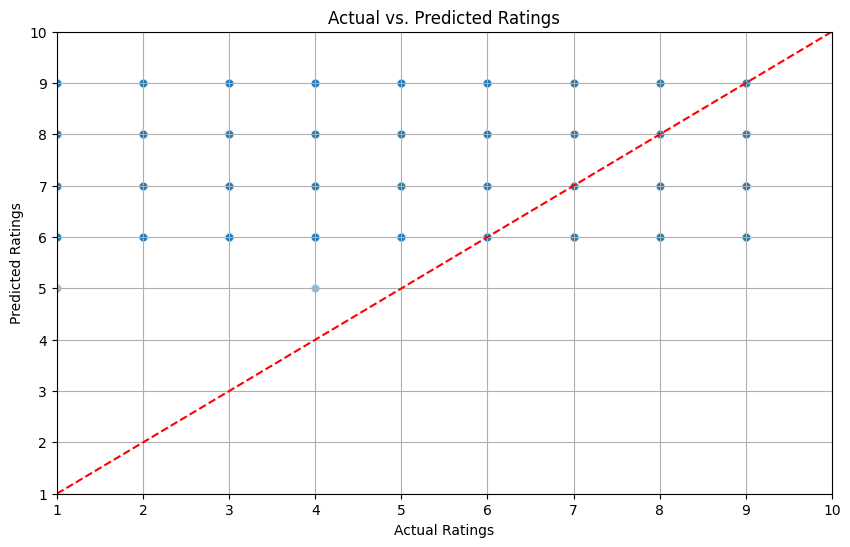

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=predicted_ratings, alpha=0.5)

plt.plot([1, 10], [1, 10], color='red', linestyle='--')


plt.title('Actual vs. Predicted Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.xlim(1, 10)  
plt.ylim(1, 10)  
plt.xticks(range(1, 11))
plt.yticks(range(1, 11))

# Show plot
plt.grid()
plt.show()

Undersampling the data based on rating to reduce the difference in number of ratings

In [77]:
rating_counts = df['rating'].value_counts()


target_sample_size = rating_counts.nlargest(5).min()


rating_under_sampled_df = df.groupby('rating').apply(lambda x: x.sample(n=min(len(x), target_sample_size), random_state=42)).reset_index(drop=True)


target_counts = rating_under_sampled_df['rating'].value_counts()

print("Under-sampled DataFrame shape:", rating_under_sampled_df.shape)
print("Counts of each class in the target variable:")
print(target_counts)

Under-sampled DataFrame shape: (521841, 51)
Counts of each class in the target variable:
rating
6.0     88831
7.0     88831
8.0     88831
9.0     88831
10.0    88831
5.0     44137
4.0     18756
3.0      7887
2.0      4136
1.0      2770
Name: count, dtype: int64


/var/folders/dz/fg9tl53x4y16ytgmdhwdt0kr0000gn/T/ipykernel_85581/1598312855.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rating_under_sampled_df = df.groupby('rating').apply(lambda x: x.sample(n=min(len(x), target_sample_size), random_state=42)).reset_index(drop=True)


Second iteration with undersampled rating data

In [78]:
# Standardize the features
features = rating_under_sampled_df.columns.difference(['user_id', 'anime_id', 'rating', 'Birthday_Date', 'Joined_Date', 'Age_Join', 'Episodes Watched',
                                  'Start Date', 'End Date', 'Name', 'Rank', 'Studios', 'Source', 'Episodes_Norm', 'Unnamed: 0'])


# # Split the data
X = rating_under_sampled_df[features]

y = rating_under_sampled_df[target]

# Ordinal Logistic Regression expects integer targets as levels
y = y.astype('category')

# # Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit an Ordinal Logistic Regression model
model_under_rating = OrderedModel(y_train, X_train, distr='logit')
model_under_rating_fit = model_under_rating.fit(method='bfgs')
print(model_under_rating_fit.summary())

# Coefficient significance
print(model_under_rating_fit.pvalues)
print(model_under_rating_fit.conf_int())

/Users/ramachandrank/Repos/MS/sem1/.venv/lib/python3.12/site-packages/statsmodels/miscmodels/ordinal_model.py:205: Warning: the endog has ordered == False, risk of capturing a wrong order for the categories. ordered == True preferred.
  warnings.warn("the endog has ordered == False, "


Optimization terminated successfully.
         Current function value: 1.921322
         Iterations: 205
         Function evaluations: 210
         Gradient evaluations: 210
                             OrderedModel Results                             
Dep. Variable:                 rating   Log-Likelihood:            -8.0210e+05
Model:                   OrderedModel   AIC:                         1.604e+06
Method:            Maximum Likelihood   BIC:                         1.605e+06
Date:                Tue, 05 Nov 2024                                         
Time:                        02:19:00                                         
No. Observations:              417472                                         
Df Residuals:                  417427                                         
Df Model:                          36                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

In [81]:

# Predict probabilities on the test set
predicted_probs = model_under_rating_fit.predict(X_test)

# Convert probabilities to predicted ratings by selecting the category with the highest probability
predicted_ratings = np.argmax(predicted_probs, axis=1)

y_test = y_test.astype('category').cat.codes + 1

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predicted_ratings)
accuracy = accuracy_score(y_test, predicted_ratings)

print("Mean Squared Error:", mse)
print("Accuracy:", accuracy)

Mean Squared Error: 5.318926117908575
Accuracy: 0.163640544606157


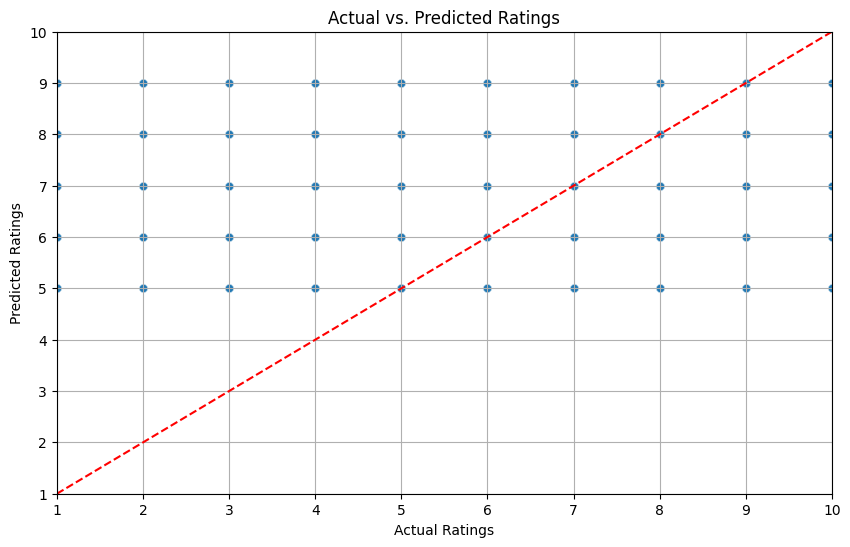

In [82]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=predicted_ratings, alpha=0.5)

plt.plot([1, 10], [1, 10], color='red', linestyle='--')

plt.title('Actual vs. Predicted Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.xlim(1, 10)  
plt.ylim(1, 10)  
plt.xticks(range(1, 11))
plt.yticks(range(1, 11))

# Show plot
plt.grid()
plt.show()

In [ ]:
import pickle

# Save the model to a file
with open('./models/ordinal_logistic_model.pkl', 'wb') as f:
    pickle.dump(model_fit, f)

In [83]:
# Standardize the features
features = rating_under_sampled_df.columns.difference(['user_id', 'anime_id', 'rating', 'Birthday_Date', 'Joined_Date', 'Age_Join', 'Episodes Watched',
                                  'Start Date', 'End Date', 'Name', 'Rank', 'Studios', 'Source', 'Episodes_Norm', 'Unnamed: 0'])
from sklearn.preprocessing import LabelEncoder, StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(rating_under_sampled_df[features])


# # Split the data
X = df_scaled

y = rating_under_sampled_df[target]

# Ordinal Logistic Regression expects integer targets as levels
y = y.astype('category')

# # Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit an Ordinal Logistic Regression model
model_under_rating_standard = OrderedModel(y_train, X_train, distr='logit')
model_under_rating_standard_fit = model_under_rating_standard.fit(method='bfgs')
print(model_under_rating_standard_fit.summary())

# Coefficient significance
print(model_under_rating_standard_fit.pvalues)
print(model_under_rating_standard_fit.conf_int())

/Users/ramachandrank/Repos/MS/sem1/.venv/lib/python3.12/site-packages/statsmodels/miscmodels/ordinal_model.py:205: Warning: the endog has ordered == False, risk of capturing a wrong order for the categories. ordered == True preferred.
  warnings.warn("the endog has ordered == False, "


Optimization terminated successfully.
         Current function value: 1.921322
         Iterations: 70
         Function evaluations: 71
         Gradient evaluations: 71
                             OrderedModel Results                             
Dep. Variable:                 rating   Log-Likelihood:            -8.0210e+05
Model:                   OrderedModel   AIC:                         1.604e+06
Method:            Maximum Likelihood   BIC:                         1.605e+06
Date:                Tue, 05 Nov 2024                                         
Time:                        02:29:34                                         
No. Observations:              417472                                         
Df Residuals:                  417427                                         
Df Model:                          36                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

In [ ]:

# Predict probabilities on the test set
predicted_probs = model_under_rating_standard_fit.predict(X_test)

# Convert probabilities to predicted ratings by selecting the category with the highest probability
predicted_ratings = np.argmax(predicted_probs, axis=1) + 1

y_test = y_test.astype('category').cat.codes + 1

# Calculate evaluation metrics
mse = mean_squared_error(y_test, predicted_ratings)
accuracy = accuracy_score(y_test, predicted_ratings)

print("Mean Squared Error:", mse)
print("Accuracy:", accuracy)

Mean Squared Error: 5.318926117908575
Accuracy: 0.163640544606157


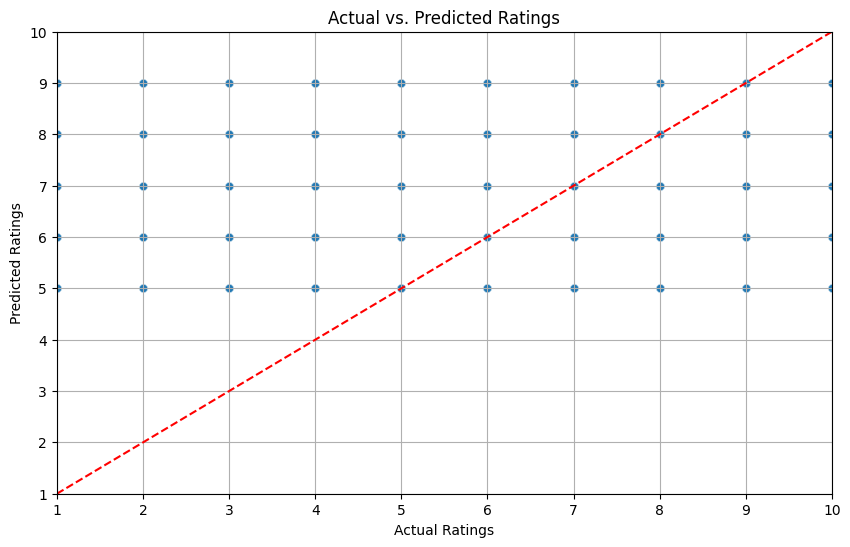

In [84]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=predicted_ratings, alpha=0.5)

plt.plot([1, 10], [1, 10], color='red', linestyle='--')

plt.title('Actual vs. Predicted Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.xlim(1, 10)  
plt.ylim(1, 10)  
plt.xticks(range(1, 11))
plt.yticks(range(1, 11))

# Show plot
plt.grid()
plt.show()

Ordered Model was not very accurate with our data. This is mostly due to the sparseness of our data after 1 hot encoding multiple class columns like location and genres.